In [80]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [81]:
def read_results_files(fname: list):
    
    df = pd.DataFrame()
    
    for f in fname:
        temp = pd.read_parquet(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'approach_tables', f'{f}.parquet'))
        df = df.append(temp, ignore_index=True)
    
    return df.reset_index()

In [146]:
df = pd.DataFrame()
files = ['chan_pool_rnn', 'chan_pool_transformer', 'chan_pool_transformer_pretrain_montage']

df = df.append(read_results_files(files))

train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
valid_cols = ['valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [86]:
df.approach.describe()

count                          360
unique                           3
top       Channel-pool Transformer
freq                           120
Name: approach, dtype: object

In [87]:
df.subject_id.describe()

count     360
unique      6
top       154
freq       60
Name: subject_id, dtype: object

# Train/test accuracy for subject 154

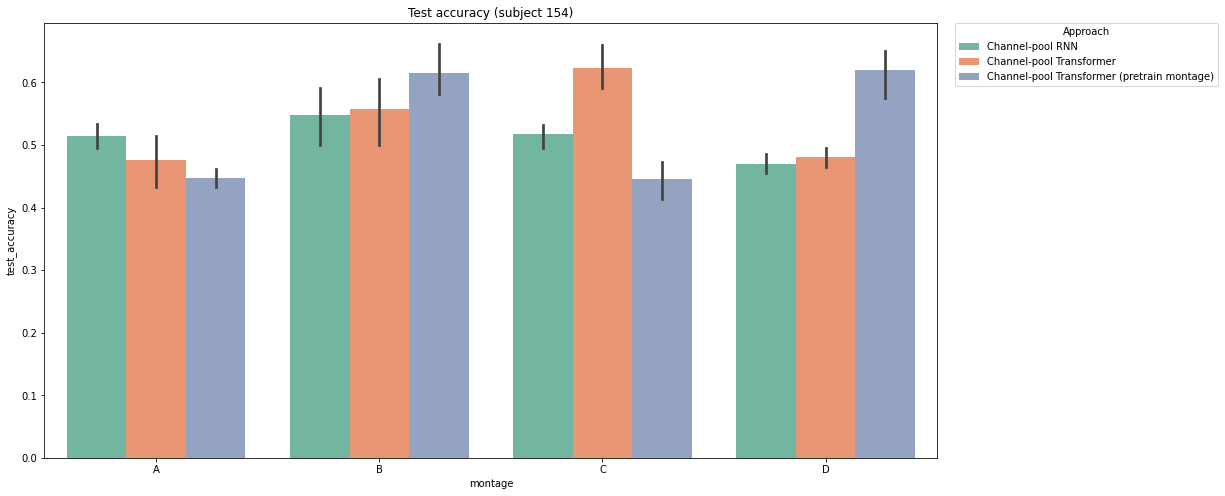

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[df['subject_id'] == '154'],
            x='montage', y='test_accuracy', hue='approach', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Approach', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Test accuracy (subject 154)');

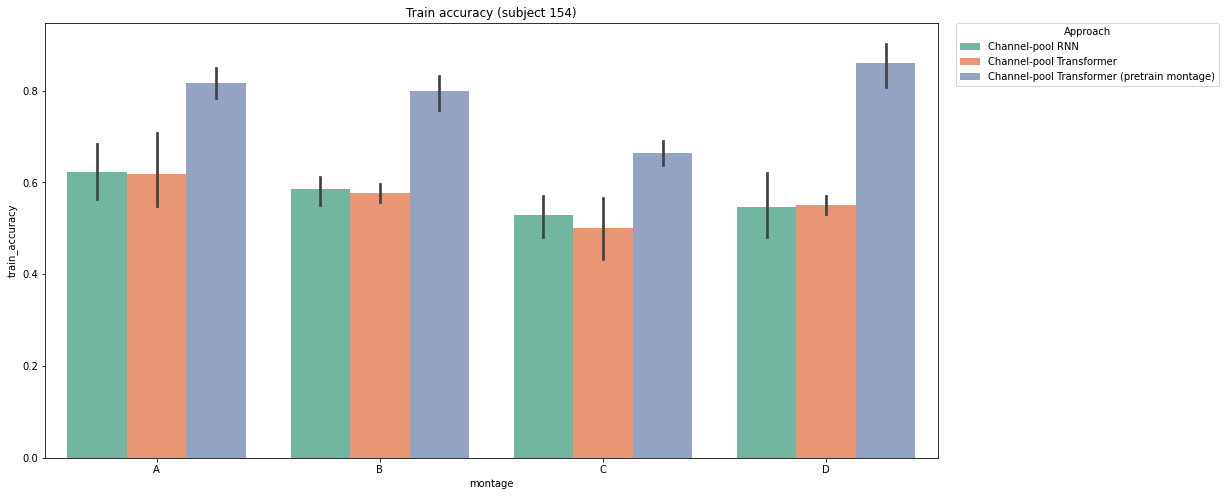

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[df['subject_id'] == '154'],
            x='montage', y='train_accuracy', hue='approach', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Approach', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Train accuracy (subject 154)');

# Multi-subject performance by approach

## Get each subject's best-performing (accuracy) CV fold to aggregate

In [181]:
best_cv_iter = dict()

for s in df.subject_id.unique():

    sub_subset = df[df['subject_id'] == s]

    grouped_metrics = sub_subset.groupby(['approach', 'cv_iter', 'montage']).mean()[valid_cols]
    max_acc_iter = grouped_metrics.groupby(['approach', 'montage']).idxmax()
    best_cv_iter[s] = dict()
    for approach in df.approach.unique():
        best_cv_iter[s][approach] = dict()
        for montage in df.montage.unique():
            best_cv_iter[s][approach][montage] = max_acc_iter.loc[(approach, montage), 'valid_accuracy'][-2]
    
best_sub_acc = pd.DataFrame()

for s in df.subject_id.unique():
    
    sub_subset = df[df['subject_id'] == s]

    grouped_metrics = sub_subset.groupby(['approach', 'cv_iter', 'montage']).mean()[test_cols]
    for approach in df.approach.unique():
        for montage in df.montage.unique():
            sub_subset_subset = sub_subset[(sub_subset['approach'] == approach) & (sub_subset['montage'] == montage) & (sub_subset['cv_iter'] == best_cv_iter[s][approach][montage])]
            best_sub_acc = best_sub_acc.append(sub_subset_subset, ignore_index=True)

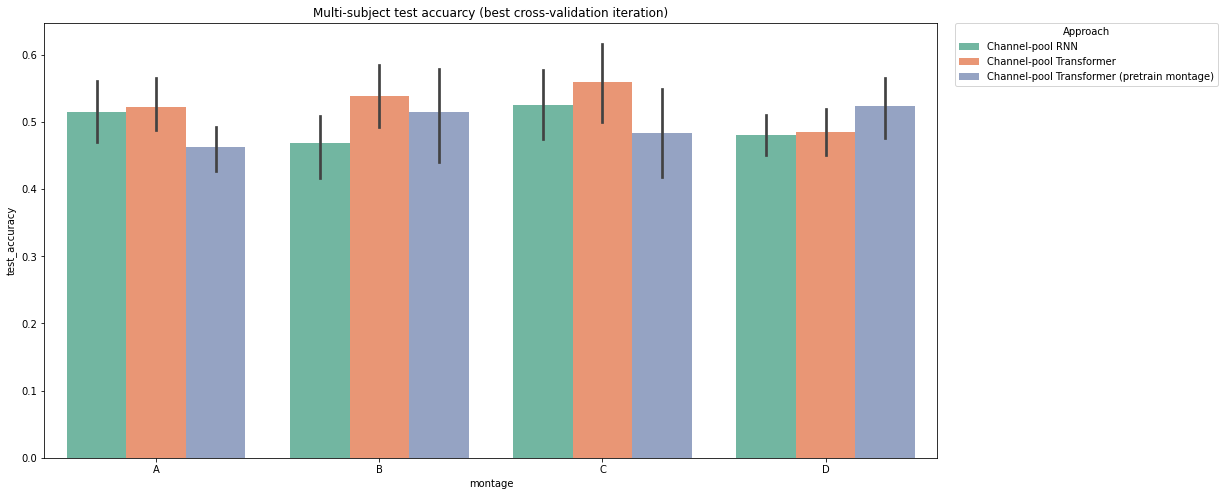

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=best_sub_acc,
            x='montage', y='test_accuracy', hue='approach', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Approach', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Multi-subject test accuarcy (best cross-validation iteration)');

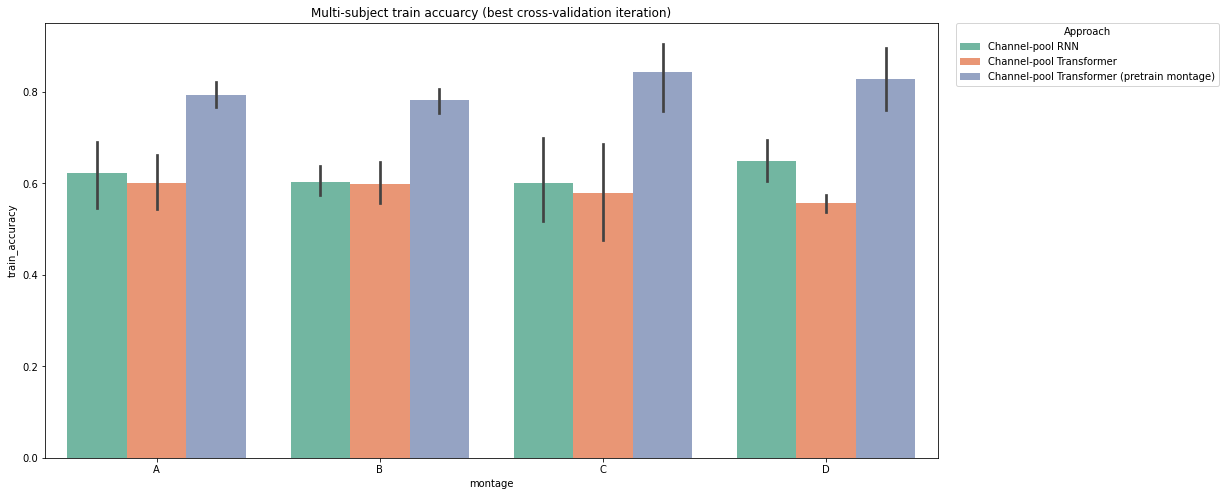

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=best_sub_acc,
            x='montage', y='train_accuracy', hue='approach', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Approach', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Multi-subject train accuarcy (best cross-validation iteration)');

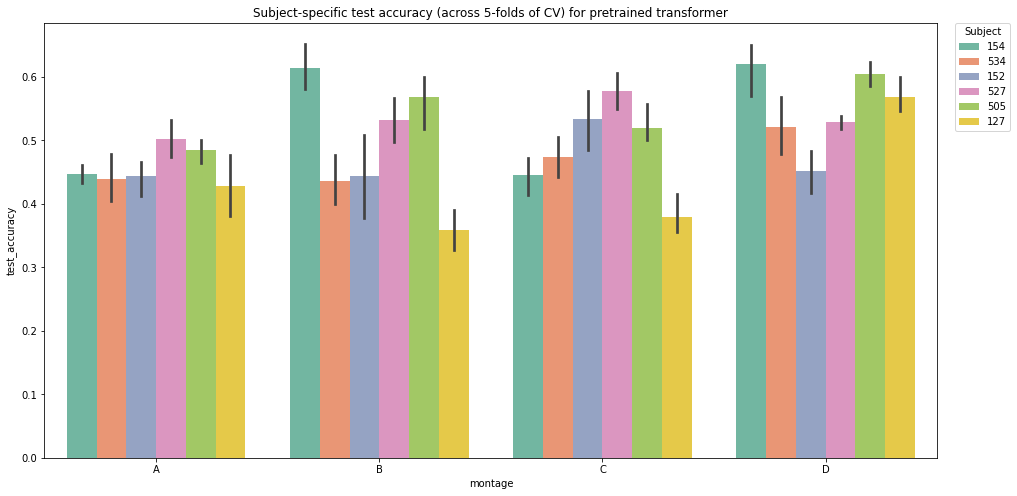

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[df['approach'] == 'Channel-pool Transformer (pretrain montage)'],
            x='montage', y='test_accuracy', hue='subject_id', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Subject-specific test accuracy (across 5-folds of CV) for pretrained transformer');

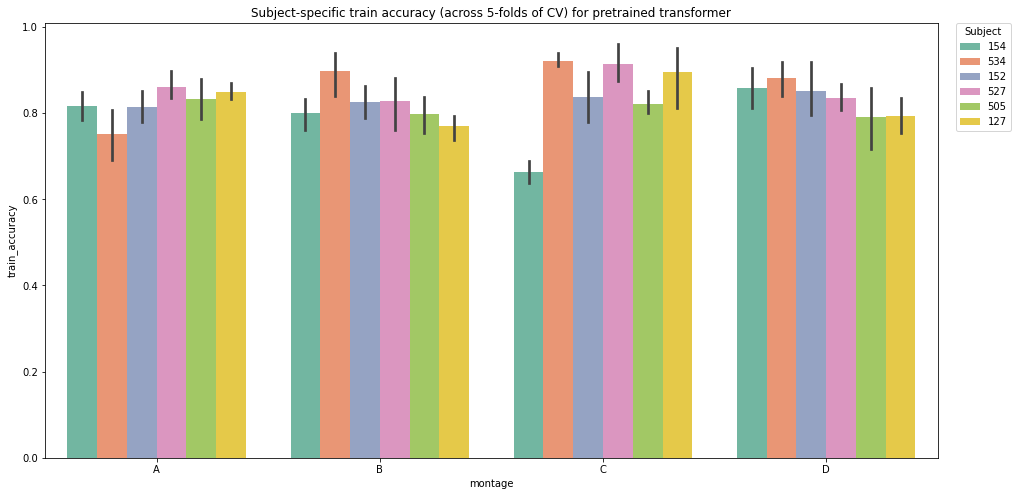

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[df['approach'] == 'Channel-pool Transformer (pretrain montage)'],
            x='montage', y='train_accuracy', hue='subject_id', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Subject', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Subject-specific train accuracy (across 5-folds of CV) for pretrained transformer');

# Multi-subject performance by metric

In [191]:
melt_test = pd.melt(best_sub_acc,
                    id_vars = ['montage', 'approach'],
                    value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                    var_name = 'metric')
melt_test.loc[:, 'metric'] = melt_test.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())

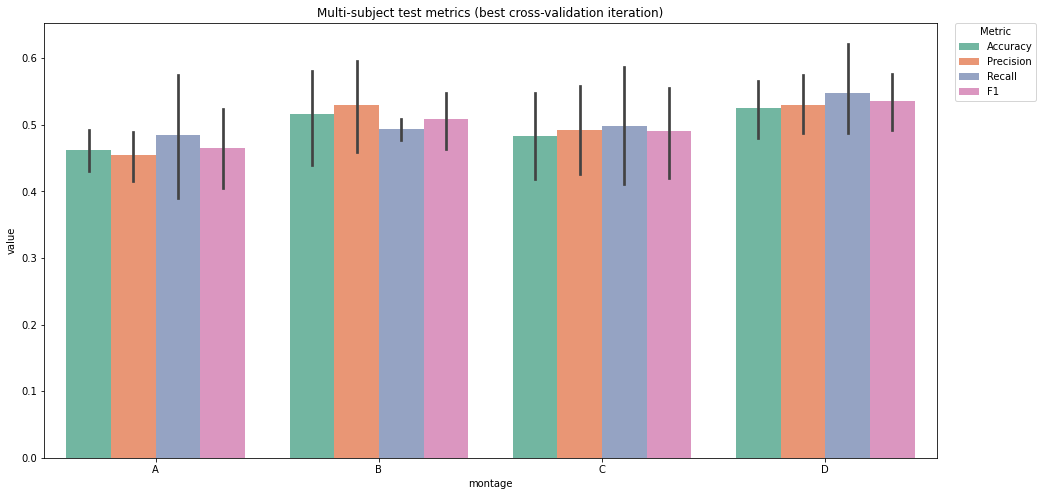

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=melt_test[melt_test['approach'] == 'Channel-pool Transformer (pretrain montage)'],
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Multi-subject test metrics (best cross-validation iteration)');

In [194]:
best_sub_acc[best_sub_acc['approach'] == 'Channel-pool Transformer (pretrain montage)'].groupby(['montage']).mean()[test_cols + train_cols].round(3)

,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1
montage,,,,,,,,
A,0.462,0.454,0.484,0.466,0.794,0.787,0.803,0.793
B,0.515,0.529,0.493,0.508,0.783,0.802,0.758,0.777
C,0.483,0.492,0.499,0.491,0.843,0.852,0.828,0.838
D,0.524,0.530,0.548,0.536,0.828,0.831,0.832,0.831
